# Correction on a disturbed solution

In [1]:
import sys
sys.path.append('../')

In [6]:
from utils import *
config = read_json_file()

method = "fem"
from solver_fem import *
ClassSolver = FEMSolver

geometry = config["geometry"]
if geometry == "circle":
    from data_circle import *
    int_a = 0.0
    int_b = 1.0
elif geometry == "square":
    from data_square import *
    int_a = -0.5
    int_b = 1.5

# homogeneous = config["homogeneous"]
homogeneous = 1
S,Sp = (0.5,0.5)
pp = 0.
if homogeneous:
    p = 0.
else:
    p = 1.

In [41]:
import os

# result_dir = "results/"
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)

# if homogeneous:
#     result_dir += "homogeneous/"
#     if not os.path.exists(result_dir):
#         os.makedirs(result_dir)
# else:
#     result_dir += "non_homogeneous/"
#     if not os.path.exists(result_dir):
#         os.makedirs(result_dir)
# result_dir += method+"_"+geometry+"/"
# if not os.path.exists(result_dir):
#         os.makedirs(result_dir)
# print(result_dir)

result_dir = "results/first_results_cvg/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [8]:
import numpy as np
import pandas as pd
import cv2
import dataframe_image as dfi
from dolfin import *

# noinspection PyUnresolvedReferences
from dolfin import parameters
import matplotlib.pyplot as plt

parameters["ghost_mode"] = "shared_facet"
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True
parameters["allow_extrapolation"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 10

## Data

In [9]:
def test_omega():
    mask = omega_mask(64)
    plt.imshow(mask)
    plt.colorbar()
    plt.show()

# test_omega()

In [10]:
def plot_data(F,U):
    mask = omega_mask(100)
    plt.figure(figsize=(9,3))

    plt.subplot(1,2,1)
    plt.imshow(mask * F, origin="lower")
    plt.title("F")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(mask * U, origin="lower")
    plt.title("U_ex")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

def test():
    f,fp = (4,1)
    XXYY = get_vert_coord(nb_vert=100)
    F = np.reshape(call_F(np,XXYY,S,f,p),[100,100])
    U = np.reshape(call_Y_true(np,XXYY,S,f,p),[100,100])
    plot_data(F,U)

# test()

## Results

In [15]:
nb_vert = 32
eps = 1e-3
tab_m = [0]+[10**i for i in range(5)]
tab_m_str = ["m = " + str(m) for m in tab_m]

In [16]:
freqs = [[3,1],[4,2],[1,2],[1,4]]
params = []
params_pert = []
for (f,fp) in freqs:
    param = [S,f,p]
    params.append(param)           
    param_pert = [Sp,fp,pp]
    params_pert.append(param_pert)
print("params : ",params)
print("params_pert : ",params_pert)
freqs_str = ["f = " + str(f) + " ; fp = " + str(fp) for ((S,f,p),(Sp,fp,pp)) in zip(params,params_pert)]
freqs_str = np.array(freqs_str)

params :  [[0.5, 3, 0.0], [0.5, 4, 0.0], [0.5, 1, 0.0], [0.5, 1, 0.0]]
params_pert :  [[0.5, 1, 0.0], [0.5, 2, 0.0], [0.5, 2, 0.0], [0.5, 4, 0.0]]


In [17]:
solver = ClassSolver(nb_cell=nb_vert-1, params=params, params_pert=params_pert)

In [ ]:
def test(eps,tab_m):
    print("eps : ",eps)
    tab_errors = []
    for i in range(len(params)):
        print("# i : ",i)
        tab_error = []
        for m in tab_m:
            print("## m = ",m)
            sol, C_h, norm_L2 = solver.corr_mult(i,eps,m)
            print("||Y_true-Y_true_corr||_L2",norm_L2)
            tab_error.append(norm_L2)
        tab_errors.append(tab_error)
        
    return np.array(tab_errors)

tab_errors = test(eps,tab_m)
np.save(result_dir+"tab_errors_reh_"+method+"_"+geometry+".npy",tab_errors)

In [ ]:
def corr_add(eps):
    print("eps : ",eps)
    tab_errors = []
    for i in range(len(params)):
        print("# i : ",i)
        sol, C_h, norm_L2 = solver.corr_add(i,eps)
        print("||Y_true-Y_true_corr||_L2",norm_L2)
        tab_errors.append(norm_L2)
        
    return np.array(tab_errors)

tab_errors_add = corr_add(eps)
np.save(result_dir+"tab_errors_add_"+method+"_"+geometry+".npy",tab_errors_add)

In [35]:
tab = np.concatenate([tab_errors,tab_errors_add[:,None]],axis=1)
np.save(result_dir+"tab_errors_"+method+"_"+geometry+".npy",tab)

In [36]:
tab_type = ["f > fp","f < fp"]
tab_type = np.repeat(tab_type,2)
index_name = np.stack((tab_type,freqs_str),axis=0)
index_name = list(zip(*index_name))
index_name = pd.MultiIndex.from_tuples(index_name)
df_errors = pd.DataFrame(tab,index=index_name,columns=tab_m_str+["Corr_add"])
df_errors

m = 0     m = 1    m = 10   m = 100  m = 1000  \
f > fp f = 3 ; fp = 1  0.001019  0.000353  0.000024  0.000021  0.000021   
       f = 4 ; fp = 2  0.000965  0.000281  0.000067  0.000066  0.000066   
f < fp f = 1 ; fp = 2  0.000333  0.000097  0.000068  0.000066  0.000066   
       f = 1 ; fp = 4  0.000715  0.000308  0.000253  0.000250  0.000249   

                       m = 10000  Corr_add  
f > fp f = 3 ; fp = 1   0.000021  0.000021  
       f = 4 ; fp = 2   0.000066  0.000066  
f < fp f = 1 ; fp = 2   0.000066  0.000066  
       f = 1 ; fp = 4   0.000249  0.000249

In [37]:
img_name = result_dir + "tab_errors_"+method+"_"+geometry+".png"
df_styled = df_errors.style.format("{:.2e}").set_properties(**{'background-color': '#ffffb3'}, subset="Corr_add")
dfi.export(df_styled,img_name)

image = cv2.imread(img_name)
image[80,:,:] = 0.0
cv2.imwrite(img_name,image)

True

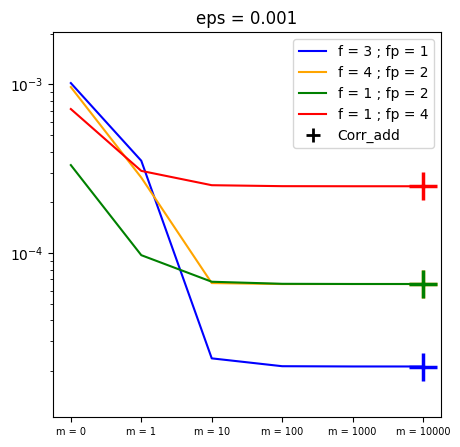

In [49]:
plt.figure(figsize=(5,5))

tab_colors=["blue","orange","green","red"]
for (i,freq_str) in enumerate(freqs_str):
    plt.semilogy(tab_errors[i],tab_colors[i],label=freq_str)
    plt.plot(tab_errors.shape[1]-1,tab_errors_add[i],"+",color=tab_colors[i],markersize=20,markeredgewidth=2.5)
plt.ylim(np.min(tab_errors)/2,np.max(tab_errors)*2)
plt.plot(0,10,"+",markersize=10,markeredgewidth=2,color="black",label="Corr_add")

plt.title("eps = "+str(eps))
plt.xticks(np.arange(0,len(tab_m),1),tab_m_str, fontsize=7)
plt.legend()
plt.savefig(result_dir+"fig_"+method+"_"+geometry+".png")
plt.show()